In [2]:
# Import modules
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import geocoder

import re

### Define function to retrieve latitudes and longitudes based on address

In [3]:
def latlong(add):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Singapore'.format(add))
      lat_lng_coords = g.latlng

    latitude = str(lat_lng_coords[0])
    longitude = lat_lng_coords[1]
    
    # put results in a list
    latlong = [str(latitude), str(longitude)]
    
    return latlong

### Scrape website for condo names and address, and combine with coordinates into a dataframe

In [4]:
az = ['A','H','M']
condonames = []
addresses = []
lat = []
long = []

for x in range(0,len(az)):
    url = "https://condo.singaporeexpats.com/name/" + az[x]
    page = urllib.request.urlopen(url)

    soup = BeautifulSoup(page, "html.parser")
    
    condo = soup.find_all('a', class_="title_link")

    for y in range(0,len(condo)):
        add = str(condo[y])
        m = re.search('>(.+?)<',add).group(1)
        condonames.append(m)

    address1 = soup.find_all('div', class_="listcol1")

    for z in range(0,len(address1)):
        m = re.search('Address: (.+?)<',str(address1[z])).group(1)
        addresses.append(m)
        
        lat.append(latlong(m)[0])
        long.append(latlong(m)[1])
        
#         print(m, latlong(m)[0], latlong(m)[1])
    
columns = ['Condo Name','Address',"Latitude",'Longitude']
condolist = pd.DataFrame(columns=columns)
condolist['Condo Name'] = condonames
condolist['Address'] = addresses
condolist['Latitude'] = lat
condolist['Longitude'] = long

In [5]:
# condolist[condolist['Condo Name'].str.contains("ADVANCE APARTMENTS")]
condolist

,Condo Name,Address,Latitude,Longitude
0,A TREASURE TROVE,50 - 76 PUNGGOL WALK,1.4060429999999968,103.89937950000001
1,AA CENTRE,336 RIVER VALLEY ROAD,1.296008999999998,103.83840450000002
2,AALTO,"191, 193 MEYER ROAD",1.2981419999999986,103.89747599999998
3,ABELIA,2A ARDMORE PARK,1.3097250000000003,103.82797800000003
4,ACACIA LODGE,530 - 540 BUKIT BATOK STREET 23,1.3400100000000066,103.75568099999998
...,...,...,...,...
145,MARYMOUNT TERRACE,2 - 84 MARYMOUNT TERRACE,1.3511430000000075,103.8401685
146,MARYMOUNT VIEW,11 PEMIMPIN DRIVE,1.3529340000000047,103.8410055
147,MATLOCK RESIDENCES,11 - 11E MATLOCK RISE,1.3474620000000073,103.86348750000002
148,MAYA,9 STILL ROAD,1.3092120000000023,103.90783950000002


In [6]:
# define foursquare credentials
CLIENT_ID = 'XALZ5A2NK4K1B2F3PLDUMTFTTL4DSELCLC5ZA5EBCEX5I511' # your Foursquare ID
CLIENT_SECRET = 'JRVVFREBWQDJQRN3QI04LLPWQUFQMA54KWPQAXUG21BD22SP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XALZ5A2NK4K1B2F3PLDUMTFTTL4DSELCLC5ZA5EBCEX5I511
CLIENT_SECRET:JRVVFREBWQDJQRN3QI04LLPWQUFQMA54KWPQAXUG21BD22SP


### Define function to retrieve venues from foursquare

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
# create the API request URL
lat=1.3139460000000014
lng=103.883265

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500,
            100)
            
# make the GET request
results = requests.get(url).json() #["response"]['groups'][0]['items']
results

{'meta': {'code': 200, 'requestId': '5ee1a7257762772fe175948f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Central Region',
  'headerFullLocation': 'Central Region, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 34,
  'suggestedBounds': {'ne': {'lat': 1.318446004500006,
    'lng': 103.88775778382036},
   'sw': {'lat': 1.3094459954999969, 'lng': 103.87877221617963}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '56e3f8becd104059d4743bbb',
       'name': 'The Skewer Bar',
       'location': {'address': '2 Lorong 25 Geylang',
        'crossStreet': 'Geylang Road',
        'lat': 1.3136741,
        'lng': 103.88387,
        'labeledLatLngs': [{'lab

In [11]:
myvenues = getNearbyVenues(names=condolist['Condo Name'],
                           latitudes=condolist['Latitude'],
                           longitudes=condolist['Longitude']
                          )


A TREASURE TROVE
AA CENTRE
AALTO
ABELIA
ACACIA LODGE
ACCORD APARTMENTS
ADAM GREEN
ADAM PARK CONDO
ADAM PLACE
ADANA @ THOMSON
ADELPHI PARK HOUSING ESTATE
ADRIA
ADVANCE APARTMENTS
AFFLUENCE COURT
AH SOO GARDENS
AIRSTREAM
AIRVIEW TOWERS
ALANA
ALBA
ALEGRIA BOUTIQUE APARTMENTS
ALESSANDREA
ALEX RESIDENCES
ALEXIS
ALIAS VILLAS
ALLAN VILLE
ALLSWORTH PARK
ALOCASSIA APARTMENTS
ALPHA APARTMENTS
ALTEZ
ALWYN PARK
AMANINDA
AMARANDA GARDEN
AMARYLLIS VILLE
AMBER GLADES
AMBER PARK
AMBER POINT
AMBER RESIDENCES
AMBER SKYE
AMPAS APARTMENTS
AMSTERDAM APARTMENT
ANDERSON GREEN
ANGSANA PARK
APARTMENT 8
APEX HARMONY LODGE
APLETON VIEW
APOLLO GARDEN
AQUARINE GARDENS
AQUARIUS BY THE PARK
AQUENE @ TELOK KURAU
ARC AT TAMPINES
H RESIDENCES
H2O RESIDENCES
HACIENDA GROVE
HAI SING PARK
HAIG 162
HAIG APARTMENTS
HAIG COURT
HAIG ELEVEN
HAIG GROVE
HAIG LODGE
HAIG MANSIONS
HAIG RESIDENCES
HAIG TEN
HAIGSVILLE
HALLMARK RESIDENCES
HAMPTON COURT
HANA
HANSON COURT
HAPPY ESTATE
HAPPY GARDENS
HAPPY MANSION
HAPPY PARK
HARBOUR SUITE

In [12]:
myvenues.rename(columns={'Neighborhood': 'Condo Name', 'Neighborhood Latitude': 'Condo Latitude', 
                         'Neighborhood Longitude': 'Condo Longitude'}, inplace=True)
myvenues

,Condo Name,Condo Latitude,Condo Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,A TREASURE TROVE,1.4060429999999968,103.89937950000001,Waterway Point,1.405425,103.902411,Shopping Mall
1,A TREASURE TROVE,1.4060429999999968,103.89937950000001,Uniqlo,1.406721,103.901837,Clothing Store
2,A TREASURE TROVE,1.4060429999999968,103.89937950000001,Swensen's,1.405930,103.901674,Ice Cream Shop
3,A TREASURE TROVE,1.4060429999999968,103.89937950000001,Shaw Theatres,1.406948,103.902423,Multiplex
4,A TREASURE TROVE,1.4060429999999968,103.89937950000001,Fairprice Fínest,1.407055,103.902348,Supermarket
...,...,...,...,...,...,...,...
4475,MAYBELLE LODGE,1.3123530000000017,103.9093335,Ichimonji,1.308870,103.911832,Ramen Restaurant
4476,MAYBELLE LODGE,1.3123530000000017,103.9093335,Geylang Lorong 29 Fried Hokkien Mee,1.308845,103.911851,Noodle House
4477,MAYBELLE LODGE,1.3123530000000017,103.9093335,Mad Nest,1.308707,103.911310,Bar
4478,MAYBELLE LODGE,1.3123530000000017,103.9093335,House of Soto,1.308784,103.911507,Soup Place


In [13]:
myvenues_onehot = pd.get_dummies(myvenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
myvenues_onehot['Condo Name'] = myvenues['Condo Name'] 

# move neighborhood column to the first column
fixed_columns = [myvenues_onehot.columns[-1]] + list(myvenues_onehot.columns[:-1])
myvenues_onehot = myvenues_onehot[fixed_columns]

myvenues_onehot.head()

,Condo Name,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zhejiang Restaurant
0,A TREASURE TROVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A TREASURE TROVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A TREASURE TROVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A TREASURE TROVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A TREASURE TROVE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
myvenues_grouped = myvenues_onehot.groupby('Condo Name').mean().reset_index()
myvenues_grouped

,Condo Name,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zhejiang Restaurant
0,A TREASURE TROVE,0.0,0.0,0.0000,0.000,0.0,0.032258,0.000000,0.0,0.0000,...,0.0,0.032258,0.0,0.032258,0.0,0.0,0.000000,0.0,0.0000,0.0
1,AA CENTRE,0.0,0.0,0.0000,0.000,0.0,0.000000,0.040000,0.0,0.0400,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0400,0.0
2,AALTO,0.0,0.0,0.0625,0.000,0.0,0.000000,0.000000,0.0,0.0625,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0625,0.0
3,ABELIA,0.0,0.0,0.0250,0.025,0.0,0.000000,0.000000,0.0,0.0000,...,0.0,0.025000,0.0,0.000000,0.0,0.0,0.025000,0.0,0.0000,0.0
4,ACACIA LODGE,0.0,0.0,0.0000,0.000,0.0,0.000000,0.000000,0.0,0.2000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,MARYMOUNT TERRACE,0.0,0.0,0.0000,0.000,0.0,0.000000,0.000000,0.0,0.0000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0
146,MARYMOUNT VIEW,0.0,0.0,0.0000,0.000,0.0,0.000000,0.000000,0.0,0.0000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0
147,MATLOCK RESIDENCES,0.0,0.0,0.0000,0.000,0.0,0.000000,0.000000,0.0,0.0000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0
148,MAYA,0.0,0.0,0.0000,0.000,0.0,0.085106,0.021277,0.0,0.0000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.021277,0.0,0.0000,0.0


### function to sort the venues in descending order

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Condo Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
myvenues_sorted = pd.DataFrame(columns=columns)
myvenues_sorted['Condo Name'] = myvenues_grouped['Condo Name']

for ind in np.arange(myvenues_grouped.shape[0]):
    myvenues_sorted.iloc[ind, 1:] = return_most_common_venues(myvenues_grouped.iloc[ind, :], num_top_venues)

myvenues_sorted.head()

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A TREASURE TROVE,Japanese Restaurant,Clothing Store,Chinese Restaurant,Café,Fast Food Restaurant,Food Court,Coffee Shop,Shopping Mall,Steakhouse,Fried Chicken Joint
1,AA CENTRE,Hotel,Ramen Restaurant,Coffee Shop,Fried Chicken Joint,Japanese Restaurant,Café,Spa,Restaurant,English Restaurant,Steakhouse
2,AALTO,Chinese Restaurant,Café,Board Shop,Club House,Thai Restaurant,Sporting Goods Shop,Flower Shop,Bar,Pizza Place,Convenience Store
3,ABELIA,Hotel,Bar,Steakhouse,Japanese Restaurant,Hotel Bar,Nightclub,Spa,Gym,Ramen Restaurant,Club House
4,ACACIA LODGE,Building,Motorcycle Shop,Gas Station,Clothing Store,BBQ Joint,Zhejiang Restaurant,Fishing Spot,Field,Filipino Restaurant,Fish & Chips Shop


### Run elbow method to determine best no. of clusters

In [21]:
myvenues_grouped2 = myvenues_grouped #drop('Condo Name', axis=0, inplace=True)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(myvenues_grouped2)
    Sum_of_squared_distances.append(km.inertia_)

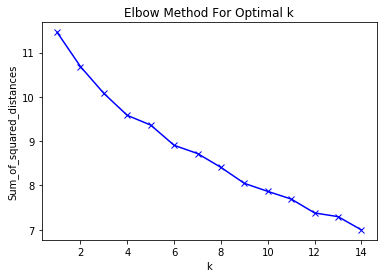

In [22]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Run k-means to cluster the neighborhood into 12 clusters.

In [28]:
# set number of clusters
kclusters = 12

myvenues_grouped_clustering = myvenues_grouped #.drop('Condo Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(myvenues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:12] 

array([ 9,  4,  3,  4,  7,  1, 11,  9, 11,  1,  1, 11])

In [32]:
# add clustering labels
myvenues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

myvenues_merged = condolist

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
myvenues_merged = myvenues_merged.join(myvenues_sorted.set_index('Condo Name'), on='Condo Name')

myvenues_merged #.head()

,Condo Name,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A TREASURE TROVE,50 - 76 PUNGGOL WALK,1.4060429999999968,103.89937950000001,9,Japanese Restaurant,Clothing Store,Chinese Restaurant,Café,Fast Food Restaurant,Food Court,Coffee Shop,Shopping Mall,Steakhouse,Fried Chicken Joint
1,AA CENTRE,336 RIVER VALLEY ROAD,1.296008999999998,103.83840450000002,4,Hotel,Ramen Restaurant,Coffee Shop,Fried Chicken Joint,Japanese Restaurant,Café,Spa,Restaurant,English Restaurant,Steakhouse
2,AALTO,"191, 193 MEYER ROAD",1.2981419999999986,103.89747599999998,3,Chinese Restaurant,Café,Board Shop,Club House,Thai Restaurant,Sporting Goods Shop,Flower Shop,Bar,Pizza Place,Convenience Store
3,ABELIA,2A ARDMORE PARK,1.3097250000000003,103.82797800000003,4,Hotel,Bar,Steakhouse,Japanese Restaurant,Hotel Bar,Nightclub,Spa,Gym,Ramen Restaurant,Club House
4,ACACIA LODGE,530 - 540 BUKIT BATOK STREET 23,1.3400100000000066,103.75568099999998,7,Building,Motorcycle Shop,Gas Station,Clothing Store,BBQ Joint,Zhejiang Restaurant,Fishing Spot,Field,Filipino Restaurant,Fish & Chips Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,MARYMOUNT TERRACE,2 - 84 MARYMOUNT TERRACE,1.3511430000000075,103.8401685,2,Chinese Restaurant,Thai Restaurant,Outdoors & Recreation,Food Court,Supermarket,Bakery,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
146,MARYMOUNT VIEW,11 PEMIMPIN DRIVE,1.3529340000000047,103.8410055,2,Chinese Restaurant,Outdoors & Recreation,Bakery,Thai Restaurant,Food Court,Food,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop
147,MATLOCK RESIDENCES,11 - 11E MATLOCK RISE,1.3474620000000073,103.86348750000002,11,Pizza Place,Bus Station,Korean Restaurant,Basketball Court,Café,Grocery Store,Dessert Shop,Flower Shop,Food,Flea Market
148,MAYA,9 STILL ROAD,1.3092120000000023,103.90783950000002,1,Chinese Restaurant,Asian Restaurant,Noodle House,Coffee Shop,Bakery,Italian Restaurant,Food Court,Café,Bar,Martial Arts Dojo


In [33]:
# create map
map_clusters = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(myvenues_merged['Latitude'], myvenues_merged['Longitude'], myvenues_merged['Condo Name'], myvenues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [41]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 0, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,ALANA,Hotel Pool,Gym,Plaza,Pool,Gym Pool,Bus Station,Field,Event Space,Farmers Market,Fast Food Restaurant
23,ALIAS VILLAS,Pizza Place,Bus Station,Bakery,Event Space,Food Stand,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
47,AQUARIUS BY THE PARK,Hotel Pool,Bus Station,Basketball Court,Fishing Spot,Steakhouse,Bus Stop,Park,Bus Line,Pizza Place,Flower Shop
81,HAWAII TOWER,Park,Bus Station,Pizza Place,Bike Rental / Bike Share,Skate Park,Trail,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
84,HEDGES PARK CONDOMINIUM,Bus Stop,Bus Station,Food & Drink Shop,Thrift / Vintage Store,Gym,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
124,MARGATE POINT,Dog Run,Park,Pool,Bus Line,Bus Stop,Bus Station,Field,Filipino Restaurant,Fish & Chips Shop,Fishing Spot


In [38]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 1, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,ACCORD APARTMENTS,Hotel,Chinese Restaurant,BBQ Joint,Thai Restaurant,Soup Place,Dim Sum Restaurant,Coffee Shop,Noodle House,Farmers Market,Seafood Restaurant
9,ADANA @ THOMSON,Chinese Restaurant,Asian Restaurant,Café,Thai Restaurant,Park,Grocery Store,Plaza,Bus Station,German Restaurant,Gift Shop
10,ADELPHI PARK HOUSING ESTATE,Bakery,Sushi Restaurant,Chinese Restaurant,Convenience Store,Pie Shop,Shopping Mall,Café,Park,Frozen Yogurt Shop,Music Store
12,ADVANCE APARTMENTS,Chinese Restaurant,Vegetarian / Vegan Restaurant,Noodle House,Seafood Restaurant,Asian Restaurant,Indian Restaurant,Japanese Restaurant,Café,Soup Place,Spa
19,ALEGRIA BOUTIQUE APARTMENTS,Bakery,Food Court,Chinese Restaurant,Bagel Shop,Gastropub,Fast Food Restaurant,Noodle House,Ramen Restaurant,Thai Restaurant,Bar
21,ALEX RESIDENCES,Chinese Restaurant,Bubble Tea Shop,Pool,Canal,Malay Restaurant,Coffee Shop,Hainan Restaurant,Harbor / Marina,Train Station,Food Court
22,ALEXIS,Chinese Restaurant,Food Court,Hainan Restaurant,Bubble Tea Shop,Housing Development,Malay Restaurant,Asian Restaurant,Pool,Train Station,Harbor / Marina
24,ALLAN VILLE,Chinese Restaurant,Coffee Shop,Food Court,Hostel,Hotel,Café,Beer Garden,Italian Restaurant,Dumpling Restaurant,Beer Bar
27,ALPHA APARTMENTS,Chinese Restaurant,Noodle House,Asian Restaurant,Indian Restaurant,Seafood Restaurant,Food Court,Bar,Bakery,Cheese Shop,Salad Place
32,AMARYLLIS VILLE,Chinese Restaurant,Italian Restaurant,Seafood Restaurant,Café,Asian Restaurant,Coffee Shop,Japanese Restaurant,Thai Restaurant,Snack Place,Food Court


In [39]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 2, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,AMANINDA,Bakery,Food Court,Chinese Restaurant,Bagel Shop,Gastropub,Fast Food Restaurant,Noodle House,Thai Restaurant,Bar,Ramen Restaurant
119,MANHATTAN MANSIONS,Chinese Restaurant,Thai Restaurant,Indian Restaurant,Fish & Chips Shop,Event Space,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Zhejiang Restaurant
145,MARYMOUNT TERRACE,Chinese Restaurant,Thai Restaurant,Outdoors & Recreation,Food Court,Supermarket,Bakery,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
146,MARYMOUNT VIEW,Chinese Restaurant,Outdoors & Recreation,Bakery,Thai Restaurant,Food Court,Food,Flower Shop,Flea Market,Fishing Spot,Fish & Chips Shop


In [40]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 3, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,AALTO,Chinese Restaurant,Café,Board Shop,Club House,Thai Restaurant,Sporting Goods Shop,Flower Shop,Bar,Pizza Place,Convenience Store
13,AFFLUENCE COURT,Japanese Restaurant,Soccer Field,Convenience Store,Indian Restaurant,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
14,AH SOO GARDENS,Dessert Shop,Ice Cream Shop,Indian Restaurant,Convenience Store,Zhejiang Restaurant,Flea Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
31,AMARANDA GARDEN,Pizza Place,Dessert Shop,Indian Restaurant,Basketball Court,Fishing Spot,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop
35,AMBER POINT,Chinese Restaurant,BBQ Joint,Thai Restaurant,Theme Park,Bar,Board Shop,Pizza Place,Café,Indian Restaurant,Club House
37,AMBER SKYE,Café,Bar,Chinese Restaurant,American Restaurant,Italian Restaurant,Board Shop,Club House,Thai Restaurant,Sporting Goods Shop,Yoga Studio
106,MACKENZIE MANSION,Indian Restaurant,Breakfast Spot,Bakery,Beer Garden,Fruit & Vegetable Store,Thai Restaurant,Noodle House,North Indian Restaurant,Playground,Chinese Restaurant
117,MANDARIN GARDENS,Convenience Store,Beach,Thai Restaurant,BBQ Joint,Gym,Chinese Restaurant,Event Space,Lake,Fishing Spot,Flea Market
120,MANILA GARDENS,Park,Cafeteria,Gastropub,Café,Garden Center,Bakery,Chinese Restaurant,Indian Restaurant,Flower Shop,Pizza Place


In [42]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 4, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,AA CENTRE,Hotel,Ramen Restaurant,Coffee Shop,Fried Chicken Joint,Japanese Restaurant,Café,Spa,Restaurant,English Restaurant,Steakhouse
3,ABELIA,Hotel,Bar,Steakhouse,Japanese Restaurant,Hotel Bar,Nightclub,Spa,Gym,Ramen Restaurant,Club House
16,AIRVIEW TOWERS,Hotel,Tea Room,Coffee Shop,Ramen Restaurant,Public Art,Gourmet Shop,Grocery Store,Movie Theater,Spa,Hainan Restaurant
18,ALBA,Hotel,Noodle House,Wine Bar,Food,Chinese Restaurant,Vietnamese Restaurant,Food Court,Thai Restaurant,Seafood Restaurant,Pub
40,ANDERSON GREEN,Hotel,Steakhouse,Seafood Restaurant,Malay Restaurant,Tennis Court,Italian Restaurant,Cantonese Restaurant,Buffet,Vegetarian / Vegan Restaurant,Chinese Restaurant
64,HALLMARK RESIDENCES,Hotel,Hotel Pool,Restaurant,Wine Bar,Steakhouse,Snack Place,Seafood Restaurant,Spa,College Academic Building,Other Great Outdoors
65,HAMPTON COURT,Hotel,Japanese Restaurant,Café,Pool,American Restaurant,Italian Restaurant,French Restaurant,Chinese Restaurant,Sushi Restaurant,Spa
66,HANA,Hotel,Bar,Deli / Bodega,Spa,Steakhouse,Lounge,Cocktail Bar,Japanese Restaurant,Supermarket,Italian Restaurant
88,HELIOS RESIDENCES,Hotel,Chinese Restaurant,Japanese Restaurant,Deli / Bodega,Indonesian Restaurant,Spa,Spanish Restaurant,Café,Steakhouse,Supermarket
91,HERITAGE APARTMENTS,Hotel,Japanese Restaurant,Spa,American Restaurant,French Restaurant,Bar,Boutique,Nightclub,Buffet,Steakhouse


In [43]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 5, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,ALESSANDREA,Park,Coffee Shop,Food & Drink Shop,Canal,Café,Pool,Supermarket,Fast Food Restaurant,Field,Filipino Restaurant
29,ALWYN PARK,Café,Playground,Ice Cream Shop,Music School,Pool,BBQ Joint,Stadium,Park,Coffee Shop,Zhejiang Restaurant
136,MARLENE VILLE,Café,Park,Coffee Shop,Playground,Ice Cream Shop,Pool,BBQ Joint,Music School,Zhejiang Restaurant,Farmers Market


In [44]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 6, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
104,MACKENZIE 138,Indian Restaurant,Breakfast Spot,Bakery,Market,Playground,Café,Cantonese Restaurant,Fruit & Vegetable Store,Motel,Sporting Goods Shop
105,MACKENZIE 88,Indian Restaurant,Vegetarian / Vegan Restaurant,Hospital,Bakery,Motel,Playground,Sporting Goods Shop,Café,Coffee Shop,Fast Food Restaurant
107,MACKENZIE REGENCY,Indian Restaurant,Vegetarian / Vegan Restaurant,Hospital,Bakery,Motel,Playground,Sporting Goods Shop,Café,Coffee Shop,Fast Food Restaurant


In [45]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 7, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,ACACIA LODGE,Building,Motorcycle Shop,Gas Station,Clothing Store,BBQ Joint,Zhejiang Restaurant,Fishing Spot,Field,Filipino Restaurant,Fish & Chips Shop


In [46]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 8, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,AMSTERDAM APARTMENT,Playground,Sporting Goods Shop,Bar,Flower Shop,Zhejiang Restaurant,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


In [47]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 9, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A TREASURE TROVE,Japanese Restaurant,Clothing Store,Chinese Restaurant,Café,Fast Food Restaurant,Food Court,Coffee Shop,Shopping Mall,Steakhouse,Fried Chicken Joint
7,ADAM PARK CONDO,Noodle House,Japanese Restaurant,Asian Restaurant,Modern European Restaurant,Dessert Shop,Café,Satay Restaurant,Malay Restaurant,Lounge,Bistro
28,ALTEZ,Japanese Restaurant,Coffee Shop,Bakery,Ramen Restaurant,Cocktail Bar,Gym / Fitness Center,Hotel,Café,Italian Restaurant,Salad Place
43,APEX HARMONY LODGE,Fast Food Restaurant,Playground,Asian Restaurant,Supermarket,Bus Station,Zhejiang Restaurant,Fishing Spot,Field,Filipino Restaurant,Fish & Chips Shop
46,AQUARINE GARDENS,Indian Restaurant,Dessert Shop,Café,Massage Studio,Spa,Chinese Restaurant,Coffee Shop,Seafood Restaurant,Asian Restaurant,Yoga Studio
49,ARC AT TAMPINES,Fast Food Restaurant,Supermarket,Coffee Shop,Thai Restaurant,Zhejiang Restaurant,Filipino Restaurant,Event Space,Farmers Market,Field,Fishing Spot
51,H2O RESIDENCES,Food Court,Coffee Shop,Bus Stop,Sandwich Place,Supermarket,Light Rail Station,Soccer Field,Residential Building (Apartment / Condo),Chinese Restaurant,Park
52,HACIENDA GROVE,Coffee Shop,Chinese Restaurant,Dessert Shop,Indian Restaurant,Spa,Gastropub,Pub,Supermarket,Café,Asian Restaurant
53,HAI SING PARK,Coffee Shop,Bus Station,Grocery Store,Chinese Restaurant,Food Court,Indian Restaurant,Asian Restaurant,Athletics & Sports,Basketball Court,Field
71,HAPPY PARK,Bus Station,Food Court,Café,Pet Store,Convenience Store,Australian Restaurant,Bus Stop,Field,Filipino Restaurant,Fish & Chips Shop


In [48]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 10, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,AIRSTREAM,Hotel Pool,Soccer Stadium,Dim Sum Restaurant,Coffee Shop,Restaurant,Chinese Restaurant,Music Store,Bus Line,Photography Studio,Harbor / Marina
102,M66,Coffee Shop,Soccer Stadium,Fast Food Restaurant,Restaurant,Music Venue,Music Store,Malay Restaurant,Market,Chinese Restaurant,Bus Line
123,MAR THOMA MANSIONS,Photography Studio,Soccer Stadium,Restaurant,Coffee Shop,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Flea Market


In [49]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 11, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,ADAM GREEN,Café,Asian Restaurant,Shopping Mall,Supermarket,Coffee Shop,Thai Restaurant,Malay Restaurant,French Restaurant,Bakery,Noodle House
8,ADAM PLACE,Café,Asian Restaurant,Shopping Mall,Supermarket,Coffee Shop,Thai Restaurant,Malay Restaurant,French Restaurant,Bakery,Noodle House
11,ADRIA,Café,Asian Restaurant,Italian Restaurant,Hotel,Coffee Shop,Food Court,Chinese Restaurant,Restaurant,Snack Place,Massage Studio
25,ALLSWORTH PARK,French Restaurant,Bar,Café,Basketball Court,Dance Studio,Thai Restaurant,Cupcake Shop,Farmers Market,Food Stand,Food Court
26,ALOCASSIA APARTMENTS,Italian Restaurant,Diner,Japanese Restaurant,Fast Food Restaurant,Café,Bus Stop,Sandwich Place,Flea Market,Flower Shop,Farmers Market
44,APLETON VIEW,Café,Coffee Shop,Asian Restaurant,Italian Restaurant,Hotel,Ramen Restaurant,Pharmacy,Japanese Restaurant,Restaurant,Sandwich Place
45,APOLLO GARDEN,Noodle House,Café,Asian Restaurant,Coffee Shop,Chinese Restaurant,Gym,Japanese Restaurant,Flower Shop,Flea Market,Fishing Spot
68,HAPPY ESTATE,Zhejiang Restaurant,Snack Place,Café,Ice Cream Shop,Indian Restaurant,Pool,Seafood Restaurant,Japanese Restaurant,Park,Filipino Restaurant
76,HARBOURSIDE APARTMENTS,Coffee Shop,Snack Place,Café,Bus Station,Deli / Bodega,Whisky Bar,Asian Restaurant,Historic Site,Japanese Restaurant,Field
90,HENRY PARK APARTMENTS,Café,French Restaurant,Bookstore,Supermarket,Thai Restaurant,Bar,Bakery,Coffee Shop,Bus Station,Bus Line


In [50]:
myvenues_merged.loc[myvenues_merged['Cluster Labels'] == 12, myvenues_merged.columns[[0] + list(range(5, myvenues_merged.shape[1]))]]

,Condo Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
